<a href="https://colab.research.google.com/github/sangwooan/-/blob/master/LSTM%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90_%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [2]:
#!pip install finance-datareader

In [3]:
import FinanceDataReader as fdr

In [4]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [5]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-09-02,58300,58600,57500,57500,15040310,-0.015411
2022-09-05,57400,57800,56800,57100,11425977,-0.006957
2022-09-06,57200,57600,56900,57100,7503086,0.000000
2022-09-07,56700,56700,55900,56000,17384854,-0.019264
2022-09-08,56200,56400,55600,55600,17632727,-0.007143


**미국 주식 데이터**도 가져올 수 있습니다.

In [6]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL')

In [7]:
apple.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2022-09-02,155.81,159.90,160.36,154.97,76310000.0,-0.0136
2022-09-06,154.53,156.42,157.07,153.73,73090000.0,-0.0082
2022-09-07,155.96,154.95,156.65,153.67,86870000.0,0.0093
2022-09-08,154.45,154.60,156.34,152.72,83840000.0,-0.0097
2022-09-09,157.37,155.41,157.78,154.76,67570000.0,0.0189


다음과 같이 `2017`을 같이 넘겨주면, 해당 시점 이후의 주식 데이터를 가져옵니다.

In [8]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL', '2017')

In [9]:
apple.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2017-01-03,29.04,28.95,29.08,28.69,115130000.0,0.0031
2017-01-04,29.00,28.96,29.13,28.94,84470000.0,-0.0014
2017-01-05,29.15,28.98,29.22,28.95,88770000.0,0.0052
2017-01-06,29.48,29.20,29.54,29.12,127010000.0,0.0113
2017-01-09,29.75,29.49,29.86,29.48,134250000.0,0.0092


**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [10]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2022-9-5')

In [11]:
ford.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-03-18,1.83,1.83,1.85,1.82,3770000.0,-0.0108
1980-03-19,1.85,1.85,1.86,1.83,1560000.0,0.0109
1980-03-20,1.86,1.86,1.88,1.85,1450000.0,0.0054
1980-03-21,1.78,1.78,1.85,1.76,5020000.0,-0.0430
1980-03-24,1.71,1.71,1.75,1.66,3330000.0,-0.0393


In [12]:
ford.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2022-08-29,15.57,15.20,15.71,15.19,50420000.0,0.0104
2022-08-30,15.45,15.70,15.80,15.17,65550000.0,-0.0077
2022-08-31,15.24,15.54,15.54,15.24,51360000.0,-0.0136
2022-09-01,15.19,15.11,15.21,14.78,65130000.0,-0.0033
2022-09-02,15.16,15.50,15.56,15.06,64410000.0,-0.0020


그 밖에 **금, 은과 같은 현물**, **달러와 같은 화폐** 데이터도 가져올 수 있습니다.

더욱 자세한 내용은 [GitHub 페이지 링크](https://github.com/FinanceData/FinanceDataReader)를 참고해 보시기 바랍니다.

In [13]:
## 주가데이터 가져오기

지난 주식 예측 튜토리얼에서는 **삼성전자** 주가데이터로 실습을 해봤으니, 

이번에는 글로벌 증시의 대장주인 **Apple**사의 주가데이터를 가져와서 예측해 보도록 하겠습니다.

In [14]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [15]:
stock = fdr.DataReader(STOCK_CODE)

In [16]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-06-27,757,780,756,769,140840,NaN
1998-06-29,781,791,765,765,330510,-0.005202
1998-06-30,765,809,755,791,373730,0.033987
1998-07-01,804,886,796,886,719666,0.120101
1998-07-02,888,921,856,869,869104,-0.019187


In [17]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-09-02,58300,58600,57500,57500,15040310,-0.015411
2022-09-05,57400,57800,56800,57100,11425977,-0.006957
2022-09-06,57200,57600,56900,57100,7503086,0.000000
2022-09-07,56700,56700,55900,56000,17384854,-0.019264
2022-09-08,56200,56400,55600,55600,17632727,-0.007143


In [18]:
stock.index

DatetimeIndex(['1998-06-27', '1998-06-29', '1998-06-30', '1998-07-01',
               '1998-07-02', '1998-07-03', '1998-07-04', '1998-07-06',
               '1998-07-07', '1998-07-08',
               ...
               '2022-08-26', '2022-08-29', '2022-08-30', '2022-08-31',
               '2022-09-01', '2022-09-02', '2022-09-05', '2022-09-06',
               '2022-09-07', '2022-09-08'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [19]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [20]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1998-06-27,757,780,756,769,140840,NaN,1998,6,27
1998-06-29,781,791,765,765,330510,-0.005202,1998,6,29
1998-06-30,765,809,755,791,373730,0.033987,1998,6,30
1998-07-01,804,886,796,886,719666,0.120101,1998,7,1
1998-07-02,888,921,856,869,869104,-0.019187,1998,7,2


## 시각화

Text(0, 0.5, 'price')

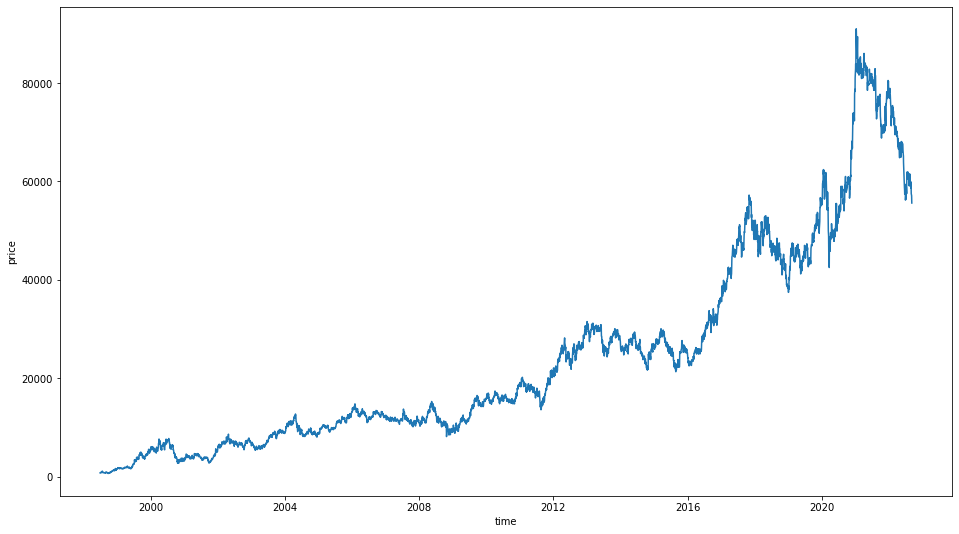

In [21]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

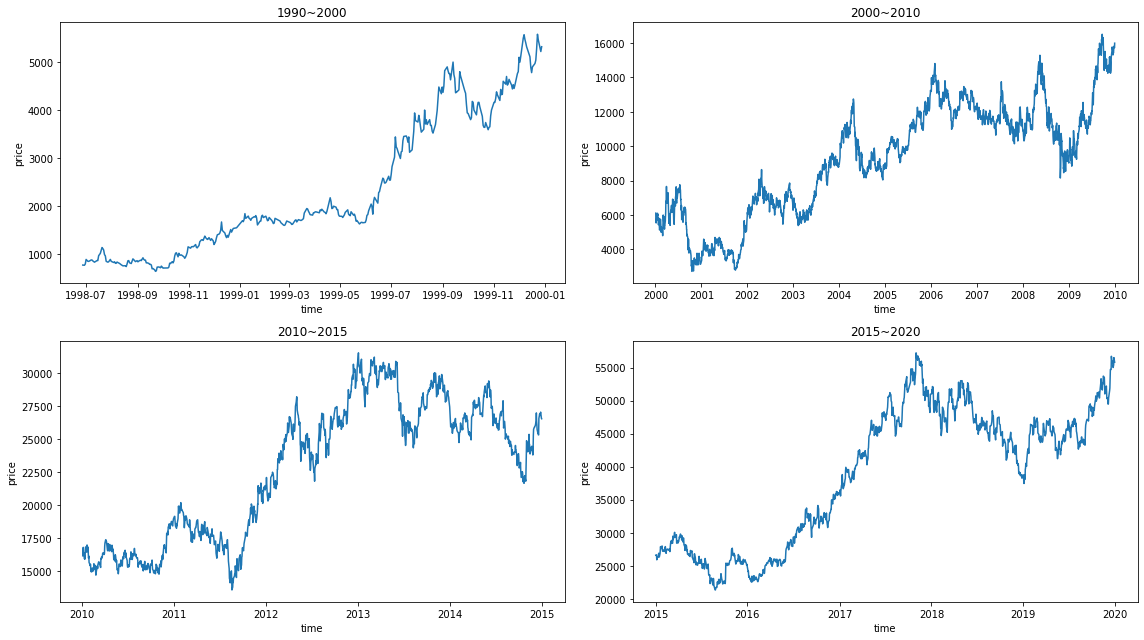

In [22]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.00838317, 0.00805785, 0.00844693, 0.00144972, 0.00155958],
       [0.00864895, 0.00817149, 0.00854749, 0.00140546, 0.00365988],
       [0.00847176, 0.00835744, 0.00843575, 0.00169319, 0.00413848],
       ...,
       [0.63344408, 0.59504132, 0.63575419, 0.6248423 , 0.08308497],
       [0.62790698, 0.5857438 , 0.62458101, 0.61266904, 0.19251013],
       [0.62236988, 0.58264463, 0.62122905, 0.6082424 , 0.19525494]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [24]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [27]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [28]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [29]:
x_train

,Open,High,Low,Volume
0,0.008383,0.008058,0.008447,0.001560
1,0.008649,0.008171,0.008547,0.003660
2,0.008472,0.008357,0.008436,0.004138
3,0.008904,0.009153,0.008894,0.007969
4,0.009834,0.009514,0.009564,0.009624
...,...,...,...,...
4795,0.584718,0.558884,0.589944,0.001778
4796,0.604651,0.564463,0.603352,0.001841
4797,0.605748,0.565909,0.603799,0.001286
4798,0.598450,0.562190,0.599989,0.001303


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [30]:
import tensorflow as tf

In [31]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [32]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [33]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [34]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [36]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [37]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [38]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    150/Unknown - 15s 7ms/step - loss: 1.3956e-04 - mse: 2.7912e-04
Epoch 1: val_loss improved from inf to 0.00055, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 16s 14ms/step - loss: 1.3956e-04 - mse: 2.7912e-04 - val_loss: 5.4719e-04 - val_mse: 0.0011
Epoch 2/50
148/150 [============================>.] - ETA: 0s - loss: 2.6124e-05 - mse: 5.2248e-05
Epoch 2: val_loss improved from 0.00055 to 0.00043, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 1s 8ms/step - loss: 2.6170e-05 - mse: 5.2340e-05 - val_loss: 4.3106e-04 - val_mse: 8.6213e-04
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 2.3290e-05 - mse: 4.6581e-05
Epoch 3: val_loss improved from 0.00043 to 0.00042, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 1s 8ms/step - loss: 2.3290e-05 - mse: 4.6581e-05 - val_loss: 4.1664e-04 - val_mse: 8.3328e-04
Epoch 4/50
142/150 [===========================>

저장한 ModelCheckpoint 를 로드합니다.

In [39]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [40]:
pred = model.predict(test_data)

In [41]:
pred.shape

(1180, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

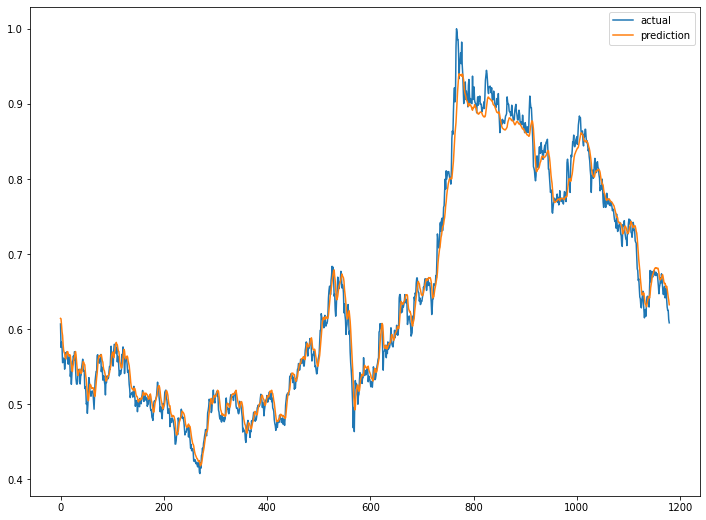

In [42]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()